In [179]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
print(device)

cuda:0


In [173]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [6]:
use_cuda = True

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=4, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=4, shuffle=True, **kwargs)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, 10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323965
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.000537
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.407783
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.038802
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.030426
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.000719
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.157353
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.004882
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.003205
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.000021
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.049954
Train Epoch: 1 [44000/60000 (73%)]	Loss: 0.001537
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.004640
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.039755
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.017360

Test set: Average loss: 0.0350, Accuracy: 9891/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000160
Train Epoch: 2 [4000/60000 (7%)]	Loss: 0.000118
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000189
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.005183
Train

In [174]:
hidden_layer_size = 122

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1, 2)
        self.conv2 = nn.Conv2d(10, 30, 5, 1, 2)
        self.fc1 = nn.Linear(30*7*7, hidden_layer_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1,30*7*7)
        x = F.relu(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_layer_size, 30*7*7)
        self.conv1 = nn.Conv2d(30, 10, 5, 1, 2)
        self.conv2 = nn.Conv2d(10, 1, 5, 1, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 30, 7, 7)
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = F.relu(self.conv1(x))
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.sigmoid(self.conv2(x))
        
        return x
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, data, reduction='mean').item() # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Total loss: {:.4f}\n'.format(test_loss))


In [175]:
use_cuda = True

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=20, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=4, shuffle=True, **kwargs)


model = AutoEncoder().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, 10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.257123
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.845597
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.832963
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.708315
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.680184
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.659762
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.601321
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.687531
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.616773
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.570756
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.600742
Train Epoch: 1 [44000/60000 (73%)]	Loss: 0.594106
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.564345
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.531110
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.563215

Test set: Total loss: 0.1416

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.540826
Train Epoch: 2 [4000/60000 (7%)]	Loss: 0.610024
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.593128
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.572556
Train Epoch: 2 [16000/60000 (27%)]	

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


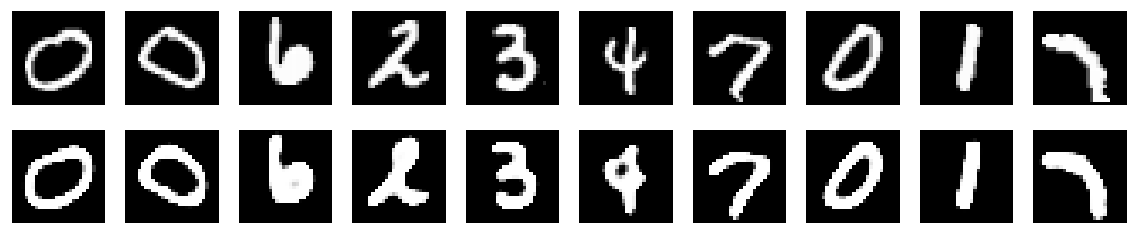

In [176]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

n = 10  # how many digits we will display

model.eval()
x_test = []
decoded_imgs = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = model(data)
        x_test += [data.cpu().numpy()[0,0,:,:]]
        decoded_imgs += [output.cpu().numpy()[0,0,:,:]]
        if len(x_test) == n:
            break
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


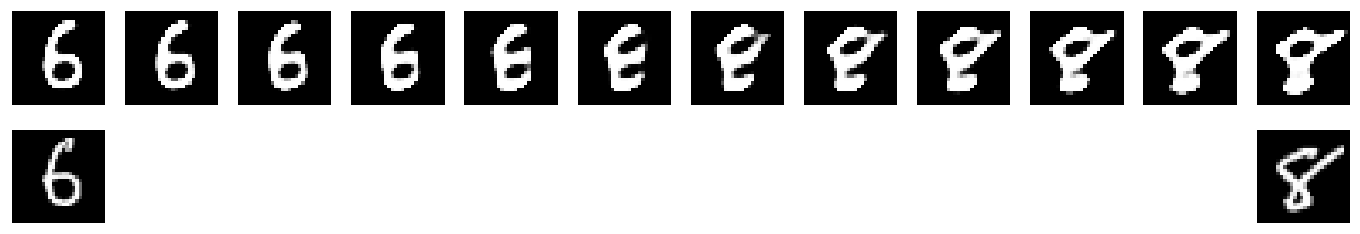

In [178]:
n = 12
encoded_vecs = torch.zeros([n, hidden_layer_size])

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        encoded = model.encoder(data)
        break
    
    first_img = data[0].cpu().numpy()[0]
    second_img = data[1].cpu().numpy()[0]
    
    encoded_vecs[0] = encoded[0]
    encoded_vecs[n-1] = encoded[1]
    for i in range(1, n-1):
        encoded_vecs[i] = ((n-i) / n) * encoded_vecs[0] + (i/n) * encoded_vecs[n-1]
        
    encoded_vecs = encoded_vecs.to(device)
    imgs = model.decoder(encoded_vecs)
    imgs = imgs.cpu().numpy()
    
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display interpolation
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

ax = plt.subplot(2, n, n+1)
plt.imshow(first_img)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, n, 2*n)
plt.imshow(second_img)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [152]:
hidden_layer_size = 122

class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        self.conv1 = nn.Conv2d(3, 30, 5, 1, 2)
        self.conv2 = nn.Conv2d(30, 72, 5, 1, 2)
        self.fc1 = nn.Linear(72*8*8, hidden_layer_size)
        
    def forward(self, x):
        x = (x - 0.5) * 2
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1,72*8*8)
        x = F.relu(self.fc1(x))
        return x
    
class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        self.fc1 = nn.Linear(hidden_layer_size, 72*8*8)
        self.conv1 = nn.Conv2d(72, 60, 5, 1, 2)
        self.conv2 = nn.Conv2d(60, 60, 5, 1, 2)
        self.conv3 = nn.Conv2d(60, 30, 5, 1, 2)
        self.conv4 = nn.Conv2d(30, 3, 5, 1, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 72, 8, 8)
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x
    
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()
        self.encoder = Encoder2()
        self.decoder = Decoder2()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy(output, data).item() # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Total loss: {:.4f}\n'.format(test_loss))


In [153]:
use_cuda = True

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

transform = transforms.Compose(
    [transforms.ToTensor()])
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

train_loader2 = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, transform=transform),
    batch_size=20, shuffle=True, **kwargs)

test_loader2 = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=transform),
    batch_size=20, shuffle=True, **kwargs)

model2 = AutoEncoder2().to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
epoch = 0

In [ ]:
for _ in range(25):
    epoch += 1
    train(model2, device, train_loader2, optimizer2, epoch)
    test(model2, device, test_loader2)

Train Epoch: 76 [0/50000 (0%)]	Loss: 0.565750
Train Epoch: 76 [4000/50000 (8%)]	Loss: 0.582572
Train Epoch: 76 [8000/50000 (16%)]	Loss: 0.554847
Train Epoch: 76 [12000/50000 (24%)]	Loss: 0.550201
Train Epoch: 76 [16000/50000 (32%)]	Loss: 0.593385
Train Epoch: 76 [20000/50000 (40%)]	Loss: 0.520538
Train Epoch: 76 [24000/50000 (48%)]	Loss: 0.558010
Train Epoch: 76 [28000/50000 (56%)]	Loss: 0.551741
Train Epoch: 76 [32000/50000 (64%)]	Loss: 0.586831
Train Epoch: 76 [36000/50000 (72%)]	Loss: 0.531751
Train Epoch: 76 [40000/50000 (80%)]	Loss: 0.557742
Train Epoch: 76 [44000/50000 (88%)]	Loss: 0.556963
Train Epoch: 76 [48000/50000 (96%)]	Loss: 0.546474

Test set: Total loss: 0.0284

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.606925
Train Epoch: 77 [4000/50000 (8%)]	Loss: 0.572616
Train Epoch: 77 [8000/50000 (16%)]	Loss: 0.556075
Train Epoch: 77 [12000/50000 (24%)]	Loss: 0.549428
Train Epoch: 77 [16000/50000 (32%)]	Loss: 0.596130
Train Epoch: 77 [20000/50000 (40%)]	Loss: 0.554944
Train Epoch: 77 

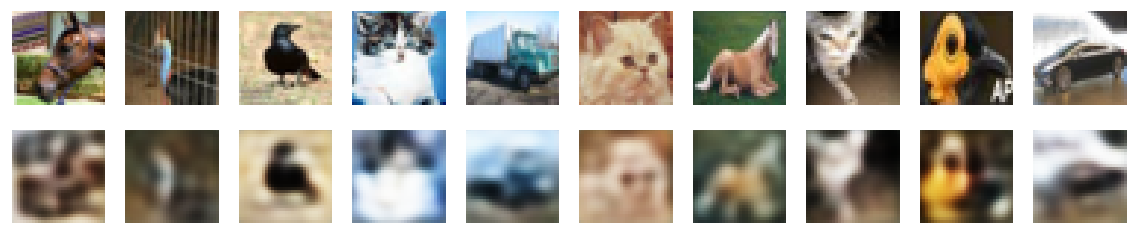

In [167]:
n = 10  # how many digits we will display

model2.eval()
x_test = []
decoded_imgs = []

denormalize = lambda x : np.transpose(x, (1, 2, 0))

with torch.no_grad():
    for data, _ in test_loader2:
        data = data.to(device)
        output = model2(data)
        x_test += [data.cpu().numpy()[0,:,:,:]]
        decoded_imgs += [output.cpu().numpy()[0,:,:,:]]
        if len(x_test) == n:
            break
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(denormalize(x_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denormalize(decoded_imgs[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

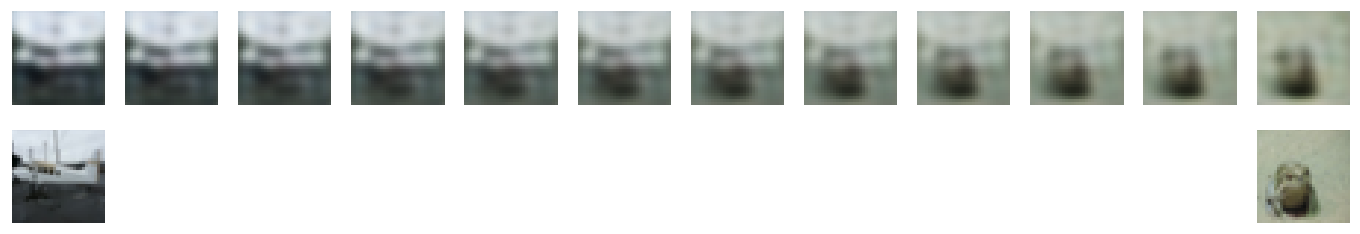

In [170]:
n = 12
encoded_vecs = torch.zeros([n, hidden_layer_size])

with torch.no_grad():
    for data, _ in test_loader2:
        data = data.to(device)
        encoded = model2.encoder(data)
        break
    
    first_img = data[0].cpu().numpy()
    second_img = data[1].cpu().numpy()
    
    encoded_vecs[0] = encoded[0]
    encoded_vecs[n-1] = encoded[1]
    for i in range(1, n-1):
        encoded_vecs[i] = ((n-i) / n) * encoded_vecs[0] + (i/n) * encoded_vecs[n-1]
        
    encoded_vecs = encoded_vecs.to(device)
    imgs = model2.decoder(encoded_vecs)
    imgs = imgs.cpu().numpy()
    
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display interpolation
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(denormalize(imgs[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

ax = plt.subplot(2, n, n+1)
plt.imshow(denormalize(first_img))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, n, 2*n)
plt.imshow(denormalize(second_img))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [244]:
hidden_layer_size = 256

class Encoder3(nn.Module):
    def __init__(self):
        super(Encoder3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv6 = nn.Conv2d(128, 128, 3, 1, 1)
        self.fc1 = nn.Linear(128*8*8, hidden_layer_size)
        
    def forward(self, x):
        x = (x - 0.5) * 2
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(-1,128*8*8)
        x = F.relu(self.fc1(x))
        return x
    
class Classifier3(nn.Module):
    def __init__(self, encoder):
        super(Classifier3, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(hidden_layer_size, 10)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x
    
class Decoder3(nn.Module):
    def __init__(self):
        super(Decoder3, self).__init__()
        self.fc1 = nn.Linear(hidden_layer_size, 256*8*8)
        self.conv1 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv2 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv3 = nn.Conv2d(256, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 128, 3, 1, 1)
        self.conv6 = nn.Conv2d(128, 128, 3, 1, 1)
        self.conv7 = nn.Conv2d(128, 3, 3, 1, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 256, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = torch.sigmoid(self.conv7(x))
        return x
    
class AutoEncoder3(nn.Module):
    def __init__(self):
        super(AutoEncoder3, self).__init__()
        self.encoder = Encoder3()
        self.decoder = Decoder3()
        self.classifier = Classifier3(self.encoder)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    
def train3_encoder(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.classifier(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test3_encoder(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model.classifier(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
def train3_decoder(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        encoded = model.encoder(data).detach()
        output = model.decoder(encoded)
        loss = F.binary_cross_entropy(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test3_decoder(model, device, test_loader):
    x_test = []
    decoded_imgs = []

    denormalize = lambda x : np.transpose(x, (1, 2, 0))

    with torch.no_grad():
        for data, _ in test_loader3:
            data = data.to(device)
            output = model3(data)
            x_test += [data.cpu().numpy()[0,:,:,:]]
            decoded_imgs += [output.cpu().numpy()[0,:,:,:]]
            if len(x_test) == n:
                break
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(denormalize(x_test[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(denormalize(decoded_imgs[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


In [245]:
use_cuda = True

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

transform = transforms.Compose(
    [transforms.ToTensor()])
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

train_loader3 = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, transform=transform),
    batch_size=20, shuffle=True, **kwargs)

test_loader3 = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=transform),
    batch_size=20, shuffle=True, **kwargs)

model3 = AutoEncoder3().to(device)
optimizer3_enc = optim.Adam(model3.classifier.parameters(), lr=0.001)
optimizer3_dec = optim.Adam(model3.decoder.parameters(), lr=0.001)
epoch_enc = 0
epoch_dec = 0

In [246]:
for _ in range(25):
    epoch_enc += 1
    train3_encoder(model3, device, train_loader3, optimizer3_enc, epoch_enc)
    test3_encoder(model3, device, test_loader3)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.314062
Train Epoch: 1 [4000/50000 (8%)]	Loss: 1.807069
Train Epoch: 1 [8000/50000 (16%)]	Loss: 1.566465
Train Epoch: 1 [12000/50000 (24%)]	Loss: 1.938959
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.411576
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.236689
Train Epoch: 1 [24000/50000 (48%)]	Loss: 2.141356
Train Epoch: 1 [28000/50000 (56%)]	Loss: 0.973066
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.208376
Train Epoch: 1 [36000/50000 (72%)]	Loss: 0.831610
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.093462
Train Epoch: 1 [44000/50000 (88%)]	Loss: 1.260034
Train Epoch: 1 [48000/50000 (96%)]	Loss: 0.830548

Test set: Average loss: 1.1285, Accuracy: 5932/10000 (59%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.044536
Train Epoch: 2 [4000/50000 (8%)]	Loss: 0.804067
Train Epoch: 2 [8000/50000 (16%)]	Loss: 0.828862
Train Epoch: 2 [12000/50000 (24%)]	Loss: 0.756163
Train Epoch: 2 [16000/50000 (32%)]	Loss: 0.903339
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.913249
Train

Train Epoch: 12 [36000/50000 (72%)]	Loss: 0.147279
Train Epoch: 12 [40000/50000 (80%)]	Loss: 0.148153
Train Epoch: 12 [44000/50000 (88%)]	Loss: 0.274538
Train Epoch: 12 [48000/50000 (96%)]	Loss: 0.206989

Test set: Average loss: 1.3946, Accuracy: 7285/10000 (73%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.160143
Train Epoch: 13 [4000/50000 (8%)]	Loss: 0.133943
Train Epoch: 13 [8000/50000 (16%)]	Loss: 0.251597
Train Epoch: 13 [12000/50000 (24%)]	Loss: 0.480002
Train Epoch: 13 [16000/50000 (32%)]	Loss: 0.325819
Train Epoch: 13 [20000/50000 (40%)]	Loss: 0.201027
Train Epoch: 13 [24000/50000 (48%)]	Loss: 0.257979
Train Epoch: 13 [28000/50000 (56%)]	Loss: 0.307443
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.317908
Train Epoch: 13 [36000/50000 (72%)]	Loss: 0.105744
Train Epoch: 13 [40000/50000 (80%)]	Loss: 0.013269
Train Epoch: 13 [44000/50000 (88%)]	Loss: 0.287270
Train Epoch: 13 [48000/50000 (96%)]	Loss: 0.237248

Test set: Average loss: 1.6626, Accuracy: 7116/10000 (71%)

Train Epoch: 14 [0/

Train Epoch: 24 [8000/50000 (16%)]	Loss: 0.047550
Train Epoch: 24 [12000/50000 (24%)]	Loss: 0.536847
Train Epoch: 24 [16000/50000 (32%)]	Loss: 0.033323
Train Epoch: 24 [20000/50000 (40%)]	Loss: 0.213712
Train Epoch: 24 [24000/50000 (48%)]	Loss: 0.483468
Train Epoch: 24 [28000/50000 (56%)]	Loss: 0.032010
Train Epoch: 24 [32000/50000 (64%)]	Loss: 0.210704
Train Epoch: 24 [36000/50000 (72%)]	Loss: 0.120207
Train Epoch: 24 [40000/50000 (80%)]	Loss: 0.328297
Train Epoch: 24 [44000/50000 (88%)]	Loss: 0.638175
Train Epoch: 24 [48000/50000 (96%)]	Loss: 0.219407

Test set: Average loss: 2.0465, Accuracy: 7038/10000 (70%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.013885
Train Epoch: 25 [4000/50000 (8%)]	Loss: 0.207947
Train Epoch: 25 [8000/50000 (16%)]	Loss: 0.048645
Train Epoch: 25 [12000/50000 (24%)]	Loss: 0.184466
Train Epoch: 25 [16000/50000 (32%)]	Loss: 0.614423
Train Epoch: 25 [20000/50000 (40%)]	Loss: 0.109967
Train Epoch: 25 [24000/50000 (48%)]	Loss: 0.035968
Train Epoch: 25 [28000/50000 (

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.693480
Train Epoch: 1 [4000/50000 (8%)]	Loss: 0.676439
Train Epoch: 1 [8000/50000 (16%)]	Loss: 0.670977
Train Epoch: 1 [12000/50000 (24%)]	Loss: 0.650524
Train Epoch: 1 [16000/50000 (32%)]	Loss: 0.671251
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.673262
Train Epoch: 1 [24000/50000 (48%)]	Loss: 0.673406
Train Epoch: 1 [28000/50000 (56%)]	Loss: 0.663200
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.652992
Train Epoch: 1 [36000/50000 (72%)]	Loss: 0.660025
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.662612
Train Epoch: 1 [44000/50000 (88%)]	Loss: 0.658202
Train Epoch: 1 [48000/50000 (96%)]	Loss: 0.667202


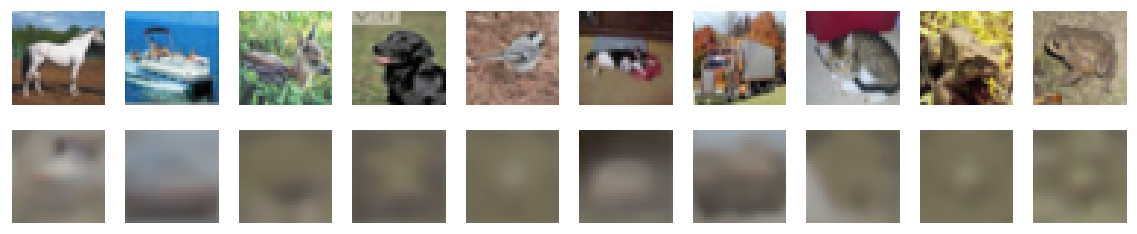

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.659638
Train Epoch: 2 [4000/50000 (8%)]	Loss: 0.660782
Train Epoch: 2 [8000/50000 (16%)]	Loss: 0.665192
Train Epoch: 2 [12000/50000 (24%)]	Loss: 0.644077
Train Epoch: 2 [16000/50000 (32%)]	Loss: 0.670303
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.649578
Train Epoch: 2 [24000/50000 (48%)]	Loss: 0.651175
Train Epoch: 2 [28000/50000 (56%)]	Loss: 0.655722
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.656354
Train Epoch: 2 [36000/50000 (72%)]	Loss: 0.675945
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.656371
Train Epoch: 2 [44000/50000 (88%)]	Loss: 0.644859
Train Epoch: 2 [48000/50000 (96%)]	Loss: 0.654858


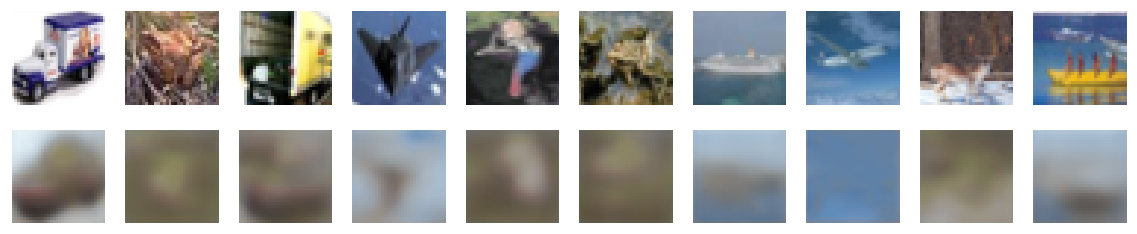

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.657064
Train Epoch: 3 [4000/50000 (8%)]	Loss: 0.632914
Train Epoch: 3 [8000/50000 (16%)]	Loss: 0.665272
Train Epoch: 3 [12000/50000 (24%)]	Loss: 0.645188
Train Epoch: 3 [16000/50000 (32%)]	Loss: 0.648067
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.665423
Train Epoch: 3 [24000/50000 (48%)]	Loss: 0.651084
Train Epoch: 3 [28000/50000 (56%)]	Loss: 0.676470
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.655926
Train Epoch: 3 [36000/50000 (72%)]	Loss: 0.659189
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.659106
Train Epoch: 3 [44000/50000 (88%)]	Loss: 0.665264
Train Epoch: 3 [48000/50000 (96%)]	Loss: 0.651421


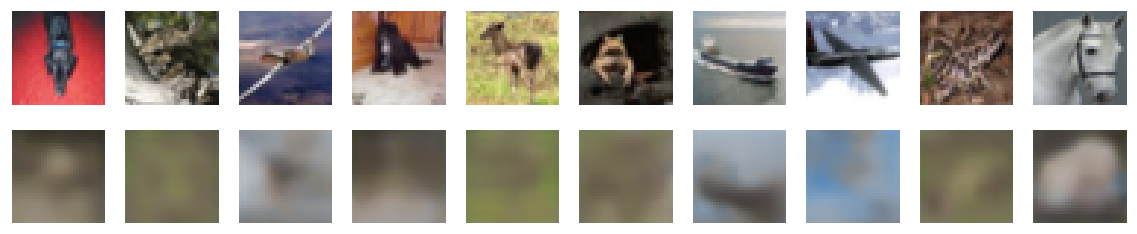

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.648837
Train Epoch: 4 [4000/50000 (8%)]	Loss: 0.636427
Train Epoch: 4 [8000/50000 (16%)]	Loss: 0.647627
Train Epoch: 4 [12000/50000 (24%)]	Loss: 0.642596
Train Epoch: 4 [16000/50000 (32%)]	Loss: 0.655041
Train Epoch: 4 [20000/50000 (40%)]	Loss: 0.657352
Train Epoch: 4 [24000/50000 (48%)]	Loss: 0.655384
Train Epoch: 4 [28000/50000 (56%)]	Loss: 0.652927
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.657663
Train Epoch: 4 [36000/50000 (72%)]	Loss: 0.653874
Train Epoch: 4 [40000/50000 (80%)]	Loss: 0.647329
Train Epoch: 4 [44000/50000 (88%)]	Loss: 0.640981
Train Epoch: 4 [48000/50000 (96%)]	Loss: 0.651876


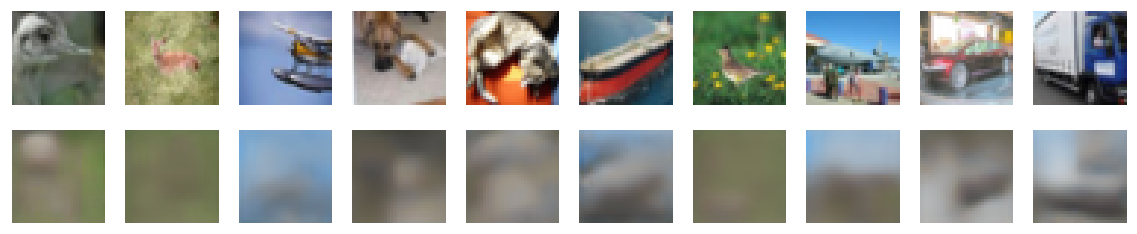

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.647830
Train Epoch: 5 [4000/50000 (8%)]	Loss: 0.621065
Train Epoch: 5 [8000/50000 (16%)]	Loss: 0.667235
Train Epoch: 5 [12000/50000 (24%)]	Loss: 0.666738
Train Epoch: 5 [16000/50000 (32%)]	Loss: 0.644324
Train Epoch: 5 [20000/50000 (40%)]	Loss: 0.630296
Train Epoch: 5 [24000/50000 (48%)]	Loss: 0.655187
Train Epoch: 5 [28000/50000 (56%)]	Loss: 0.637834
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.628086
Train Epoch: 5 [36000/50000 (72%)]	Loss: 0.655705
Train Epoch: 5 [40000/50000 (80%)]	Loss: 0.659513
Train Epoch: 5 [44000/50000 (88%)]	Loss: 0.644417
Train Epoch: 5 [48000/50000 (96%)]	Loss: 0.650427


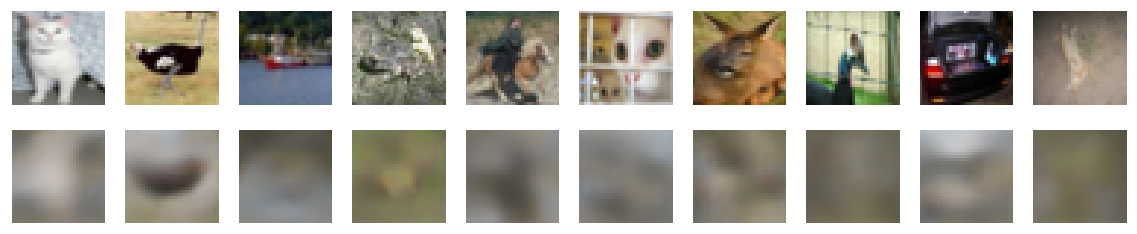

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.644355
Train Epoch: 6 [4000/50000 (8%)]	Loss: 0.637113
Train Epoch: 6 [8000/50000 (16%)]	Loss: 0.625479
Train Epoch: 6 [12000/50000 (24%)]	Loss: 0.613853
Train Epoch: 6 [16000/50000 (32%)]	Loss: 0.631469
Train Epoch: 6 [20000/50000 (40%)]	Loss: 0.636892
Train Epoch: 6 [24000/50000 (48%)]	Loss: 0.635584
Train Epoch: 6 [28000/50000 (56%)]	Loss: 0.641601
Train Epoch: 6 [32000/50000 (64%)]	Loss: 0.615919
Train Epoch: 6 [36000/50000 (72%)]	Loss: 0.642843
Train Epoch: 6 [40000/50000 (80%)]	Loss: 0.656149
Train Epoch: 6 [44000/50000 (88%)]	Loss: 0.631554
Train Epoch: 6 [48000/50000 (96%)]	Loss: 0.621927


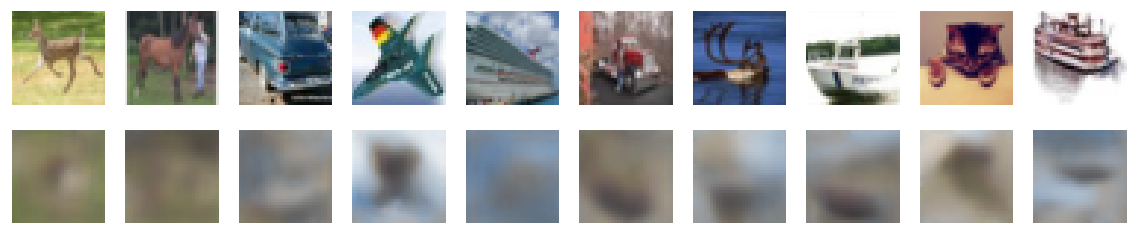

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.649315
Train Epoch: 7 [4000/50000 (8%)]	Loss: 0.623069
Train Epoch: 7 [8000/50000 (16%)]	Loss: 0.639641
Train Epoch: 7 [12000/50000 (24%)]	Loss: 0.606895
Train Epoch: 7 [16000/50000 (32%)]	Loss: 0.599469
Train Epoch: 7 [20000/50000 (40%)]	Loss: 0.629379
Train Epoch: 7 [24000/50000 (48%)]	Loss: 0.639349
Train Epoch: 7 [28000/50000 (56%)]	Loss: 0.661404
Train Epoch: 7 [32000/50000 (64%)]	Loss: 0.650377
Train Epoch: 7 [36000/50000 (72%)]	Loss: 0.635130
Train Epoch: 7 [40000/50000 (80%)]	Loss: 0.636202
Train Epoch: 7 [44000/50000 (88%)]	Loss: 0.649175
Train Epoch: 7 [48000/50000 (96%)]	Loss: 0.657167


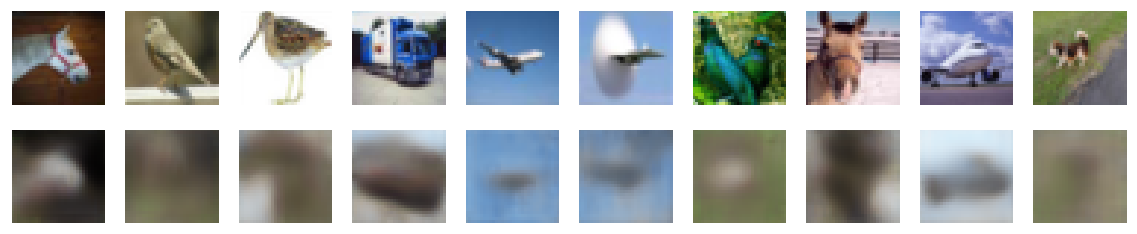

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.618098
Train Epoch: 8 [4000/50000 (8%)]	Loss: 0.636745
Train Epoch: 8 [8000/50000 (16%)]	Loss: 0.648006
Train Epoch: 8 [12000/50000 (24%)]	Loss: 0.633554
Train Epoch: 8 [16000/50000 (32%)]	Loss: 0.588305
Train Epoch: 8 [20000/50000 (40%)]	Loss: 0.629988
Train Epoch: 8 [24000/50000 (48%)]	Loss: 0.619533
Train Epoch: 8 [28000/50000 (56%)]	Loss: 0.626568
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.615280
Train Epoch: 8 [36000/50000 (72%)]	Loss: 0.623705
Train Epoch: 8 [40000/50000 (80%)]	Loss: 0.620676
Train Epoch: 8 [44000/50000 (88%)]	Loss: 0.607132
Train Epoch: 8 [48000/50000 (96%)]	Loss: 0.638456


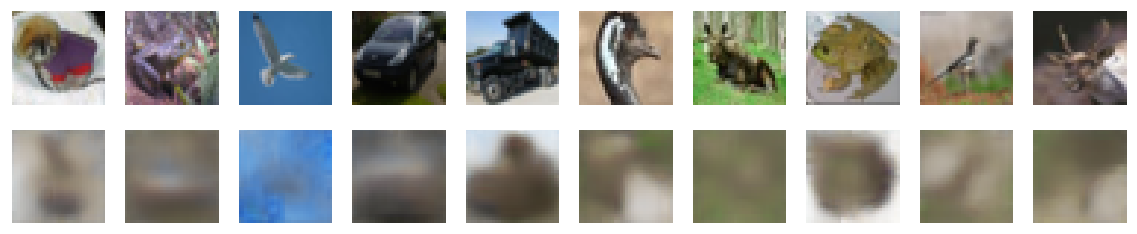

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.598449
Train Epoch: 9 [4000/50000 (8%)]	Loss: 0.610114
Train Epoch: 9 [8000/50000 (16%)]	Loss: 0.606970
Train Epoch: 9 [12000/50000 (24%)]	Loss: 0.604878
Train Epoch: 9 [16000/50000 (32%)]	Loss: 0.629926
Train Epoch: 9 [20000/50000 (40%)]	Loss: 0.626243
Train Epoch: 9 [24000/50000 (48%)]	Loss: 0.635651
Train Epoch: 9 [28000/50000 (56%)]	Loss: 0.615276
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.600797
Train Epoch: 9 [36000/50000 (72%)]	Loss: 0.608387
Train Epoch: 9 [40000/50000 (80%)]	Loss: 0.651509
Train Epoch: 9 [44000/50000 (88%)]	Loss: 0.674148
Train Epoch: 9 [48000/50000 (96%)]	Loss: 0.614059


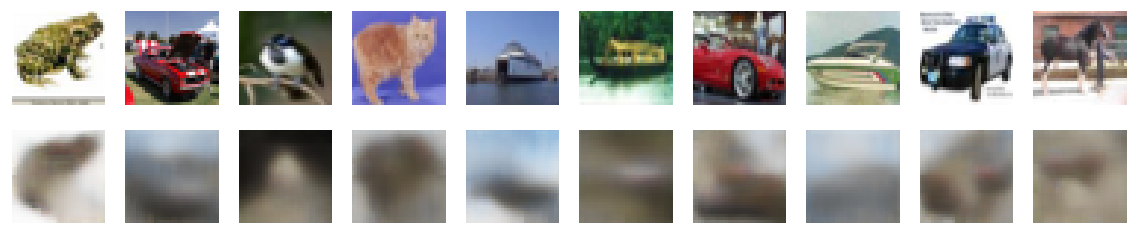

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.612149
Train Epoch: 10 [4000/50000 (8%)]	Loss: 0.628128
Train Epoch: 10 [8000/50000 (16%)]	Loss: 0.611748
Train Epoch: 10 [12000/50000 (24%)]	Loss: 0.623334
Train Epoch: 10 [16000/50000 (32%)]	Loss: 0.638345
Train Epoch: 10 [20000/50000 (40%)]	Loss: 0.627225
Train Epoch: 10 [24000/50000 (48%)]	Loss: 0.638221
Train Epoch: 10 [28000/50000 (56%)]	Loss: 0.607640
Train Epoch: 10 [32000/50000 (64%)]	Loss: 0.620563
Train Epoch: 10 [36000/50000 (72%)]	Loss: 0.614437
Train Epoch: 10 [40000/50000 (80%)]	Loss: 0.618527
Train Epoch: 10 [44000/50000 (88%)]	Loss: 0.604321
Train Epoch: 10 [48000/50000 (96%)]	Loss: 0.628749


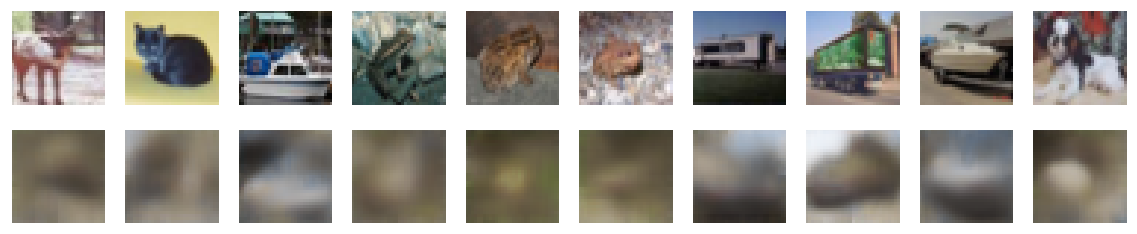

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.637749
Train Epoch: 11 [4000/50000 (8%)]	Loss: 0.604625
Train Epoch: 11 [8000/50000 (16%)]	Loss: 0.614500
Train Epoch: 11 [12000/50000 (24%)]	Loss: 0.619518
Train Epoch: 11 [16000/50000 (32%)]	Loss: 0.643110
Train Epoch: 11 [20000/50000 (40%)]	Loss: 0.555559
Train Epoch: 11 [24000/50000 (48%)]	Loss: 0.634857
Train Epoch: 11 [28000/50000 (56%)]	Loss: 0.600155
Train Epoch: 11 [32000/50000 (64%)]	Loss: 0.638658
Train Epoch: 11 [36000/50000 (72%)]	Loss: 0.630998
Train Epoch: 11 [40000/50000 (80%)]	Loss: 0.621010
Train Epoch: 11 [44000/50000 (88%)]	Loss: 0.612639
Train Epoch: 11 [48000/50000 (96%)]	Loss: 0.619215


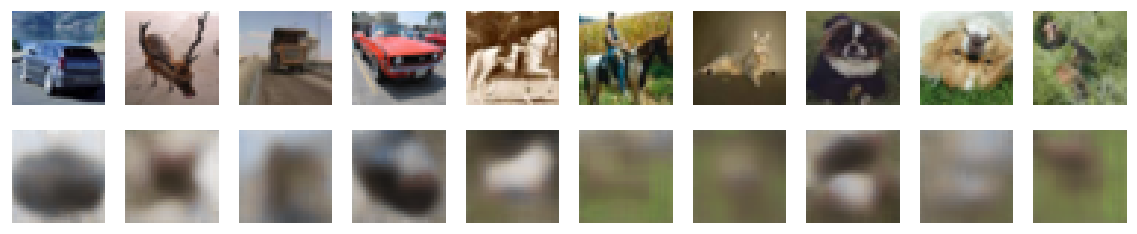

Train Epoch: 12 [0/50000 (0%)]	Loss: 0.590727
Train Epoch: 12 [4000/50000 (8%)]	Loss: 0.623991
Train Epoch: 12 [8000/50000 (16%)]	Loss: 0.636350
Train Epoch: 12 [12000/50000 (24%)]	Loss: 0.642819
Train Epoch: 12 [16000/50000 (32%)]	Loss: 0.630599
Train Epoch: 12 [20000/50000 (40%)]	Loss: 0.636910
Train Epoch: 12 [24000/50000 (48%)]	Loss: 0.641779
Train Epoch: 12 [28000/50000 (56%)]	Loss: 0.652517
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.619370
Train Epoch: 12 [36000/50000 (72%)]	Loss: 0.625412
Train Epoch: 12 [40000/50000 (80%)]	Loss: 0.607729
Train Epoch: 12 [44000/50000 (88%)]	Loss: 0.611274
Train Epoch: 12 [48000/50000 (96%)]	Loss: 0.602289


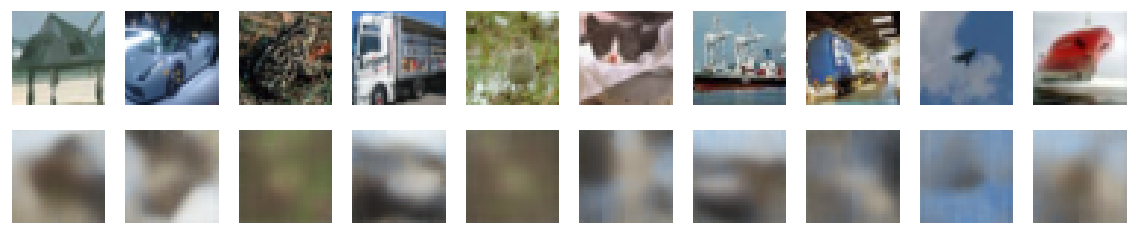

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.612559
Train Epoch: 13 [4000/50000 (8%)]	Loss: 0.583002
Train Epoch: 13 [8000/50000 (16%)]	Loss: 0.607201
Train Epoch: 13 [12000/50000 (24%)]	Loss: 0.611166
Train Epoch: 13 [16000/50000 (32%)]	Loss: 0.659270
Train Epoch: 13 [20000/50000 (40%)]	Loss: 0.605299
Train Epoch: 13 [24000/50000 (48%)]	Loss: 0.610897
Train Epoch: 13 [28000/50000 (56%)]	Loss: 0.619415
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.595382
Train Epoch: 13 [36000/50000 (72%)]	Loss: 0.594630
Train Epoch: 13 [40000/50000 (80%)]	Loss: 0.583345
Train Epoch: 13 [44000/50000 (88%)]	Loss: 0.613938
Train Epoch: 13 [48000/50000 (96%)]	Loss: 0.600358


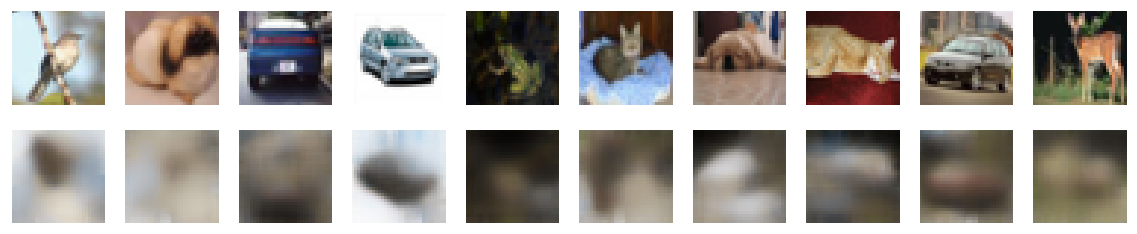

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.609755
Train Epoch: 14 [4000/50000 (8%)]	Loss: 0.614175
Train Epoch: 14 [8000/50000 (16%)]	Loss: 0.617096
Train Epoch: 14 [12000/50000 (24%)]	Loss: 0.611907
Train Epoch: 14 [16000/50000 (32%)]	Loss: 0.586429
Train Epoch: 14 [20000/50000 (40%)]	Loss: 0.604783
Train Epoch: 14 [24000/50000 (48%)]	Loss: 0.605089
Train Epoch: 14 [28000/50000 (56%)]	Loss: 0.618278
Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.609202
Train Epoch: 14 [36000/50000 (72%)]	Loss: 0.626436
Train Epoch: 14 [40000/50000 (80%)]	Loss: 0.607709
Train Epoch: 14 [44000/50000 (88%)]	Loss: 0.630168
Train Epoch: 14 [48000/50000 (96%)]	Loss: 0.618866


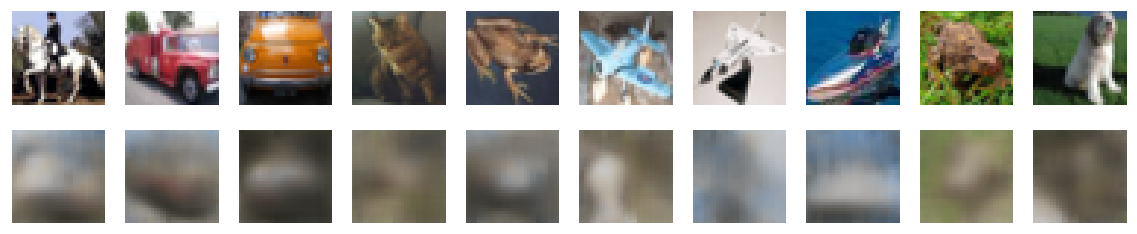

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.607176
Train Epoch: 15 [4000/50000 (8%)]	Loss: 0.597671
Train Epoch: 15 [8000/50000 (16%)]	Loss: 0.625487
Train Epoch: 15 [12000/50000 (24%)]	Loss: 0.600821
Train Epoch: 15 [16000/50000 (32%)]	Loss: 0.607566
Train Epoch: 15 [20000/50000 (40%)]	Loss: 0.632237
Train Epoch: 15 [24000/50000 (48%)]	Loss: 0.574793
Train Epoch: 15 [28000/50000 (56%)]	Loss: 0.611785
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.622208
Train Epoch: 15 [36000/50000 (72%)]	Loss: 0.634316
Train Epoch: 15 [40000/50000 (80%)]	Loss: 0.608947
Train Epoch: 15 [44000/50000 (88%)]	Loss: 0.612782
Train Epoch: 15 [48000/50000 (96%)]	Loss: 0.600061


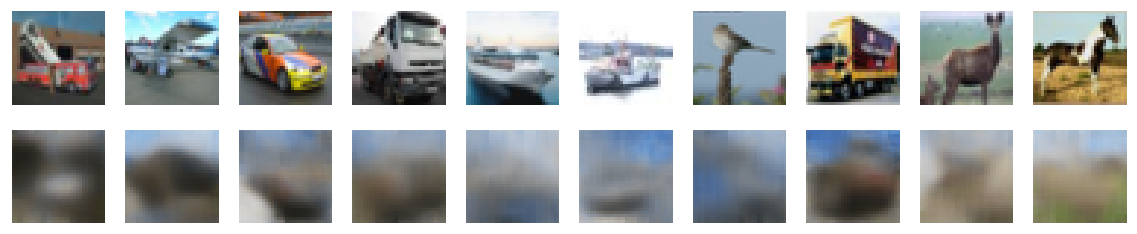

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.615808
Train Epoch: 16 [4000/50000 (8%)]	Loss: 0.627330
Train Epoch: 16 [8000/50000 (16%)]	Loss: 0.602315
Train Epoch: 16 [12000/50000 (24%)]	Loss: 0.619202
Train Epoch: 16 [16000/50000 (32%)]	Loss: 0.581870
Train Epoch: 16 [20000/50000 (40%)]	Loss: 0.632933
Train Epoch: 16 [24000/50000 (48%)]	Loss: 0.634061
Train Epoch: 16 [28000/50000 (56%)]	Loss: 0.628030
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.614099
Train Epoch: 16 [36000/50000 (72%)]	Loss: 0.632915
Train Epoch: 16 [40000/50000 (80%)]	Loss: 0.630841
Train Epoch: 16 [44000/50000 (88%)]	Loss: 0.626619
Train Epoch: 16 [48000/50000 (96%)]	Loss: 0.609431


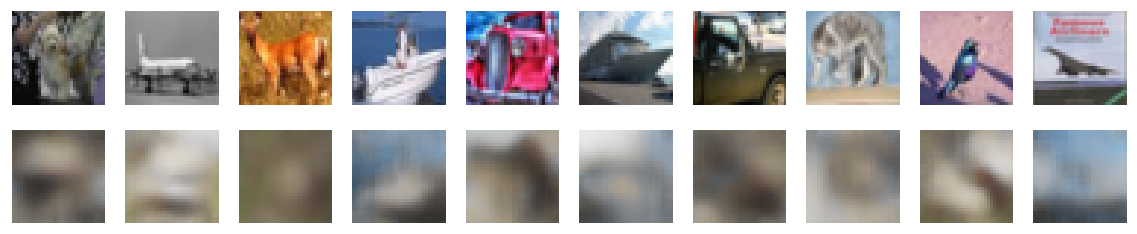

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.621348
Train Epoch: 17 [4000/50000 (8%)]	Loss: 0.620338
Train Epoch: 17 [8000/50000 (16%)]	Loss: 0.617141
Train Epoch: 17 [12000/50000 (24%)]	Loss: 0.591177
Train Epoch: 17 [16000/50000 (32%)]	Loss: 0.603166
Train Epoch: 17 [20000/50000 (40%)]	Loss: 0.588252
Train Epoch: 17 [24000/50000 (48%)]	Loss: 0.623114
Train Epoch: 17 [28000/50000 (56%)]	Loss: 0.584641
Train Epoch: 17 [32000/50000 (64%)]	Loss: 0.597211
Train Epoch: 17 [36000/50000 (72%)]	Loss: 0.607560
Train Epoch: 17 [40000/50000 (80%)]	Loss: 0.593811
Train Epoch: 17 [44000/50000 (88%)]	Loss: 0.587279
Train Epoch: 17 [48000/50000 (96%)]	Loss: 0.616196


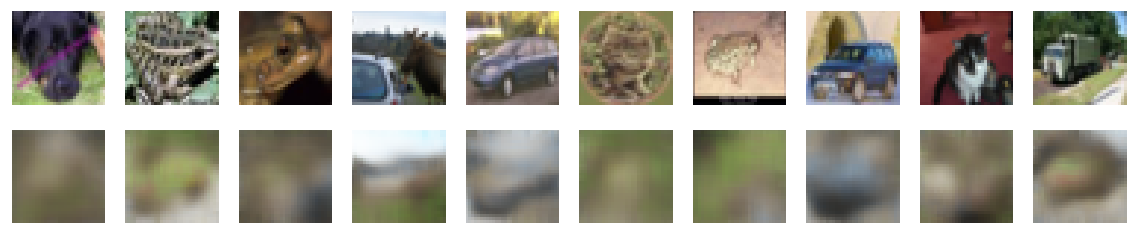

Train Epoch: 18 [0/50000 (0%)]	Loss: 0.612645
Train Epoch: 18 [4000/50000 (8%)]	Loss: 0.607953
Train Epoch: 18 [8000/50000 (16%)]	Loss: 0.606847
Train Epoch: 18 [12000/50000 (24%)]	Loss: 0.612323
Train Epoch: 18 [16000/50000 (32%)]	Loss: 0.576977
Train Epoch: 18 [20000/50000 (40%)]	Loss: 0.593307
Train Epoch: 18 [24000/50000 (48%)]	Loss: 0.613211
Train Epoch: 18 [28000/50000 (56%)]	Loss: 0.628838
Train Epoch: 18 [32000/50000 (64%)]	Loss: 0.626259
Train Epoch: 18 [36000/50000 (72%)]	Loss: 0.610314
Train Epoch: 18 [40000/50000 (80%)]	Loss: 0.607920
Train Epoch: 18 [44000/50000 (88%)]	Loss: 0.623442
Train Epoch: 18 [48000/50000 (96%)]	Loss: 0.571754


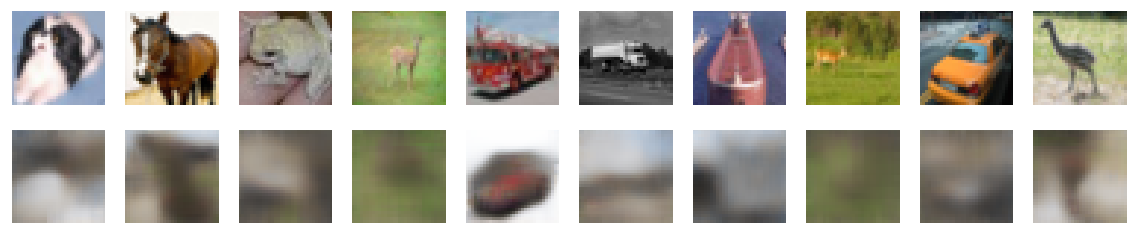

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.592990
Train Epoch: 19 [4000/50000 (8%)]	Loss: 0.611910
Train Epoch: 19 [8000/50000 (16%)]	Loss: 0.636466
Train Epoch: 19 [12000/50000 (24%)]	Loss: 0.614752
Train Epoch: 19 [16000/50000 (32%)]	Loss: 0.598779
Train Epoch: 19 [20000/50000 (40%)]	Loss: 0.595482
Train Epoch: 19 [24000/50000 (48%)]	Loss: 0.608637
Train Epoch: 19 [28000/50000 (56%)]	Loss: 0.625748
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.622215
Train Epoch: 19 [36000/50000 (72%)]	Loss: 0.613724
Train Epoch: 19 [40000/50000 (80%)]	Loss: 0.589369
Train Epoch: 19 [44000/50000 (88%)]	Loss: 0.600840
Train Epoch: 19 [48000/50000 (96%)]	Loss: 0.591920


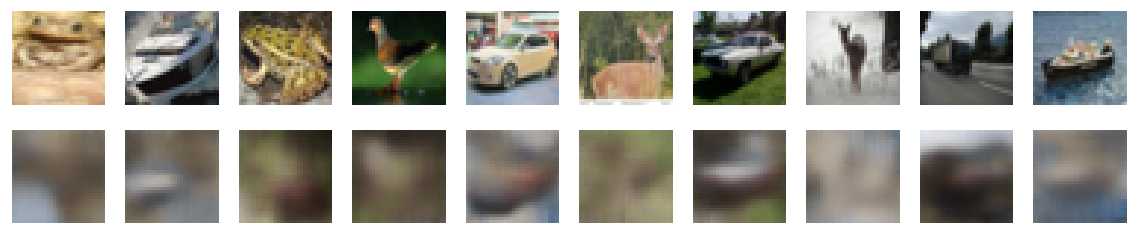

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.576283
Train Epoch: 20 [4000/50000 (8%)]	Loss: 0.616706
Train Epoch: 20 [8000/50000 (16%)]	Loss: 0.561091
Train Epoch: 20 [12000/50000 (24%)]	Loss: 0.592615
Train Epoch: 20 [16000/50000 (32%)]	Loss: 0.610333
Train Epoch: 20 [20000/50000 (40%)]	Loss: 0.605484
Train Epoch: 20 [24000/50000 (48%)]	Loss: 0.589923
Train Epoch: 20 [28000/50000 (56%)]	Loss: 0.603340
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.635038
Train Epoch: 20 [36000/50000 (72%)]	Loss: 0.623605
Train Epoch: 20 [40000/50000 (80%)]	Loss: 0.606325
Train Epoch: 20 [44000/50000 (88%)]	Loss: 0.604217
Train Epoch: 20 [48000/50000 (96%)]	Loss: 0.622926


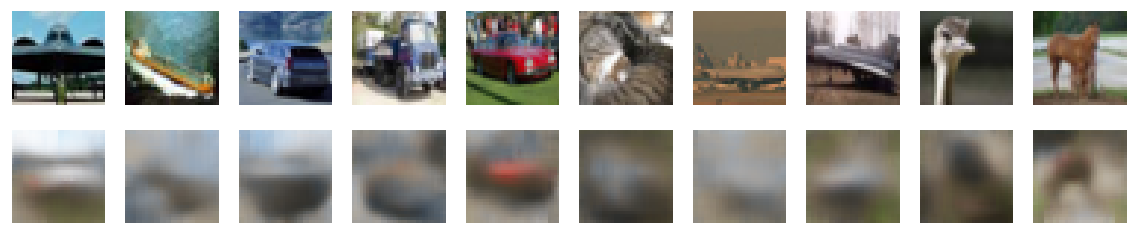

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.564240
Train Epoch: 21 [4000/50000 (8%)]	Loss: 0.600989
Train Epoch: 21 [8000/50000 (16%)]	Loss: 0.598288
Train Epoch: 21 [12000/50000 (24%)]	Loss: 0.575755
Train Epoch: 21 [16000/50000 (32%)]	Loss: 0.612293
Train Epoch: 21 [20000/50000 (40%)]	Loss: 0.622528
Train Epoch: 21 [24000/50000 (48%)]	Loss: 0.600450
Train Epoch: 21 [28000/50000 (56%)]	Loss: 0.611041
Train Epoch: 21 [32000/50000 (64%)]	Loss: 0.612625
Train Epoch: 21 [36000/50000 (72%)]	Loss: 0.590131
Train Epoch: 21 [40000/50000 (80%)]	Loss: 0.586586
Train Epoch: 21 [44000/50000 (88%)]	Loss: 0.621033
Train Epoch: 21 [48000/50000 (96%)]	Loss: 0.601397


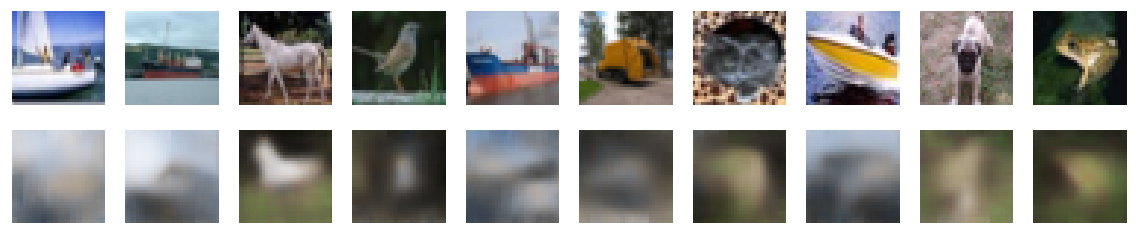

Train Epoch: 22 [0/50000 (0%)]	Loss: 0.603442
Train Epoch: 22 [4000/50000 (8%)]	Loss: 0.626742
Train Epoch: 22 [8000/50000 (16%)]	Loss: 0.569837
Train Epoch: 22 [12000/50000 (24%)]	Loss: 0.598716
Train Epoch: 22 [16000/50000 (32%)]	Loss: 0.597853
Train Epoch: 22 [20000/50000 (40%)]	Loss: 0.611099
Train Epoch: 22 [24000/50000 (48%)]	Loss: 0.620170
Train Epoch: 22 [28000/50000 (56%)]	Loss: 0.595572
Train Epoch: 22 [32000/50000 (64%)]	Loss: 0.613266
Train Epoch: 22 [36000/50000 (72%)]	Loss: 0.606158
Train Epoch: 22 [40000/50000 (80%)]	Loss: 0.632859
Train Epoch: 22 [44000/50000 (88%)]	Loss: 0.581422
Train Epoch: 22 [48000/50000 (96%)]	Loss: 0.588325


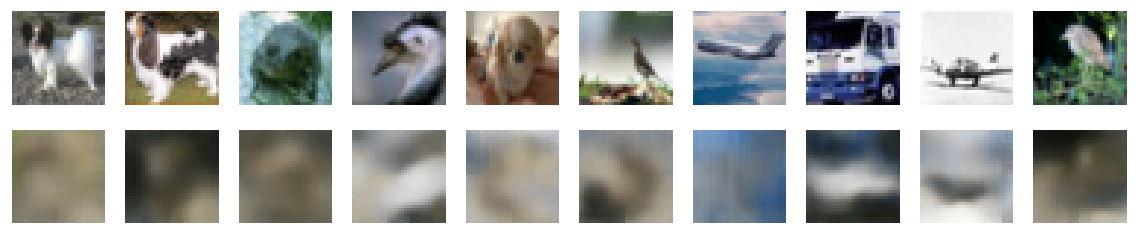

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.629596
Train Epoch: 23 [4000/50000 (8%)]	Loss: 0.604092
Train Epoch: 23 [8000/50000 (16%)]	Loss: 0.627215
Train Epoch: 23 [12000/50000 (24%)]	Loss: 0.605218
Train Epoch: 23 [16000/50000 (32%)]	Loss: 0.608207
Train Epoch: 23 [20000/50000 (40%)]	Loss: 0.597120
Train Epoch: 23 [24000/50000 (48%)]	Loss: 0.630699
Train Epoch: 23 [28000/50000 (56%)]	Loss: 0.584039
Train Epoch: 23 [32000/50000 (64%)]	Loss: 0.604819
Train Epoch: 23 [36000/50000 (72%)]	Loss: 0.594752
Train Epoch: 23 [40000/50000 (80%)]	Loss: 0.588075
Train Epoch: 23 [44000/50000 (88%)]	Loss: 0.600813
Train Epoch: 23 [48000/50000 (96%)]	Loss: 0.586624


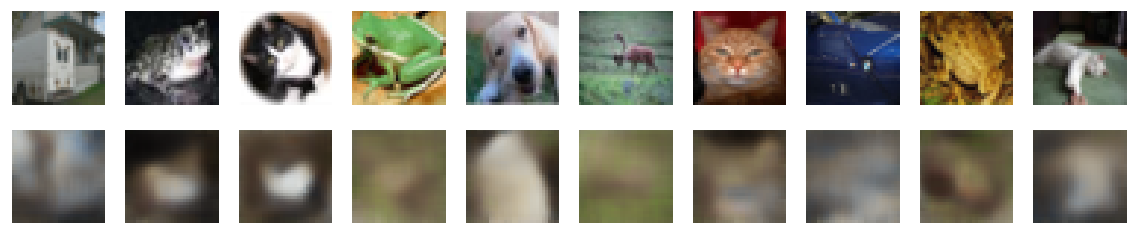

Train Epoch: 24 [0/50000 (0%)]	Loss: 0.601348
Train Epoch: 24 [4000/50000 (8%)]	Loss: 0.592910
Train Epoch: 24 [8000/50000 (16%)]	Loss: 0.593017
Train Epoch: 24 [12000/50000 (24%)]	Loss: 0.622455
Train Epoch: 24 [16000/50000 (32%)]	Loss: 0.611410
Train Epoch: 24 [20000/50000 (40%)]	Loss: 0.605914
Train Epoch: 24 [24000/50000 (48%)]	Loss: 0.608262
Train Epoch: 24 [28000/50000 (56%)]	Loss: 0.578522
Train Epoch: 24 [32000/50000 (64%)]	Loss: 0.638126
Train Epoch: 24 [36000/50000 (72%)]	Loss: 0.617562
Train Epoch: 24 [40000/50000 (80%)]	Loss: 0.576523
Train Epoch: 24 [44000/50000 (88%)]	Loss: 0.579964
Train Epoch: 24 [48000/50000 (96%)]	Loss: 0.591540


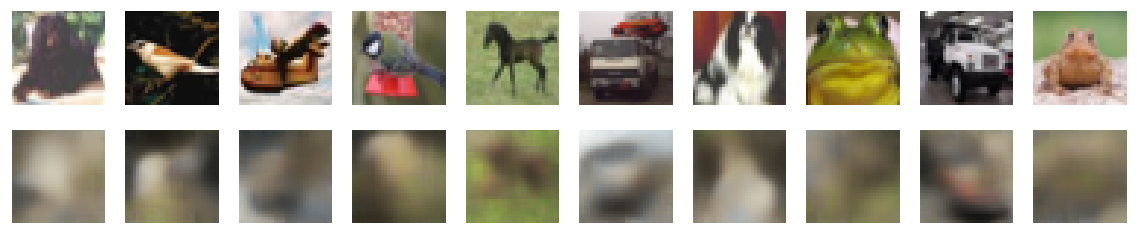

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.571682
Train Epoch: 25 [4000/50000 (8%)]	Loss: 0.605334
Train Epoch: 25 [8000/50000 (16%)]	Loss: 0.604792
Train Epoch: 25 [12000/50000 (24%)]	Loss: 0.609576
Train Epoch: 25 [16000/50000 (32%)]	Loss: 0.600890
Train Epoch: 25 [20000/50000 (40%)]	Loss: 0.604337
Train Epoch: 25 [24000/50000 (48%)]	Loss: 0.616660
Train Epoch: 25 [28000/50000 (56%)]	Loss: 0.592936
Train Epoch: 25 [32000/50000 (64%)]	Loss: 0.565522
Train Epoch: 25 [36000/50000 (72%)]	Loss: 0.600985
Train Epoch: 25 [40000/50000 (80%)]	Loss: 0.610374
Train Epoch: 25 [44000/50000 (88%)]	Loss: 0.599277
Train Epoch: 25 [48000/50000 (96%)]	Loss: 0.601923


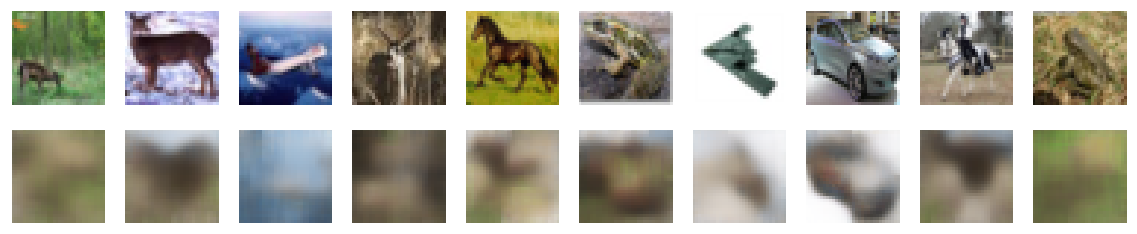

In [247]:
for _ in range(25):
    epoch_dec += 1
    train3_decoder(model3, device, train_loader3, optimizer3_dec, epoch_dec)
    test3_decoder(model3, device, test_loader3)

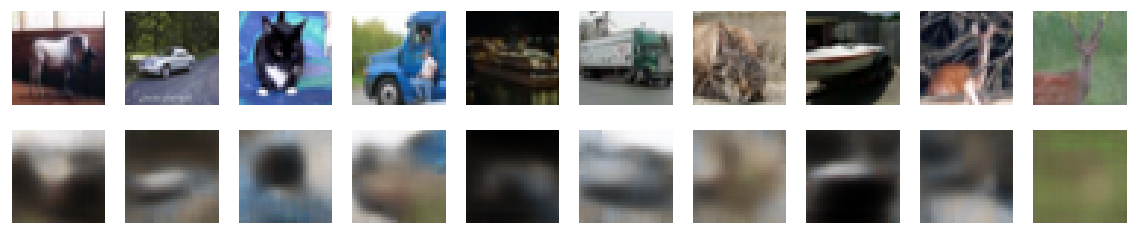

In [250]:
n = 10  # how many digits we will display

model3.eval()
x_test = []
decoded_imgs = []

denormalize = lambda x : np.transpose(x, (1, 2, 0))

with torch.no_grad():
    for data, _ in train_loader3:
        data = data.to(device)
        output = model3(data)
        x_test += [data.cpu().numpy()[0,:,:,:]]
        decoded_imgs += [output.cpu().numpy()[0,:,:,:]]
        if len(x_test) == n:
            break
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(denormalize(x_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denormalize(decoded_imgs[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

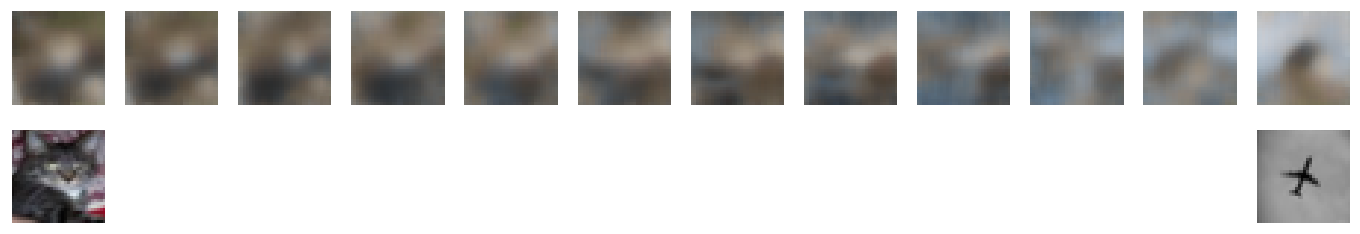

In [249]:
n = 12
encoded_vecs = torch.zeros([n, hidden_layer_size])

with torch.no_grad():
    for data, _ in test_loader3:
        data = data.to(device)
        encoded = model3.encoder(data)
        break
    
    first_img = data[0].cpu().numpy()
    second_img = data[1].cpu().numpy()
    
    encoded_vecs[0] = encoded[0]
    encoded_vecs[n-1] = encoded[1]
    for i in range(1, n-1):
        encoded_vecs[i] = ((n-i) / n) * encoded_vecs[0] + (i/n) * encoded_vecs[n-1]
        
    encoded_vecs = encoded_vecs.to(device)
    imgs = model3.decoder(encoded_vecs)
    imgs = imgs.cpu().numpy()
    
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display interpolation
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(denormalize(imgs[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

ax = plt.subplot(2, n, n+1)
plt.imshow(denormalize(first_img))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, n, 2*n)
plt.imshow(denormalize(second_img))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()